## Problema de Otimização do Transporte

Aluno: José Henrique K. Larcher

Professor: Heitor Silvério Lopes

-------------------------------------

Imports e setups.

In [2]:
!pip install deap
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
random.seed(0)
np.random.seed(0)

Dados do problema.

In [3]:
demanda = pd.read_csv('demanda.csv', index_col='origem').fillna(0)
custos = pd.read_csv('custos.csv', index_col='origem').fillna(0)
distancias = pd.read_csv('distancias.csv', index_col='origem').fillna(0)
remuneracao = pd.read_csv('remuneracao.csv', index_col='origem').fillna(0)

veiculos_carga = 11
vel_c_carga = 55
vel_s_carga	= 75
t_carga	= 2
t_descarga = 2
tamanho_frota = 68
cobertura_min = 0.72
t_max_viagem = 30*24

t_viagem = t_carga + t_descarga + np.ceil(distancias.values/vel_c_carga) + np.ceil(distancias.values/vel_s_carga)

Funções de geração aleatória e de fitness.

In [4]:
def n_caminhoes():
  return np.random.randint(0, 8, size=1)[0] # random.choices(range(0, 20), k=27)

def evaluate(individual):

  penalidade = 0.0

  #individual = individual[0]
  caminhoes = pd.DataFrame([
    [0, individual[0], individual[1], individual[2], individual[3], individual[4], 0],
    [individual[5], individual[6], 0, individual[7], 0, individual[8], individual[9]],
    [0, individual[10], 0, 0, individual[11], 0, individual[12]],
    [individual[13], 0, individual[14], 0, individual[15], individual[16], 0],
    [0, individual[17], individual[18], 0, 0, 0, individual[19]],
    [0, 0, 0, individual[20], individual[21], individual[22], individual[23]],
    [individual[24], 0, 0, individual[25], individual[26], 0, 0]
  ])

  n_viagens = caminhoes.values * np.floor(t_max_viagem/t_viagem)
  n_veiculos =  (n_viagens * veiculos_carga)*(((n_viagens * veiculos_carga) <= demanda.values) * (demanda.values != 0)) + (demanda.values)*(((n_viagens * veiculos_carga) > demanda.values) * (demanda.values != 0))
  n_viagens = np.floor(n_veiculos / veiculos_carga)
  n_veiculos =  (n_viagens * veiculos_carga)

  remuneracao_ind = np.sum( remuneracao.values * n_viagens )
  custos_ind = np.sum( custos.values * n_viagens )

  total_caminhoes = np.sum(caminhoes.values)

  cobertura = np.sum(n_veiculos) / np.sum(demanda.values)

  if np.any(np.sum(1*(caminhoes != 0), axis=1) < 2):
    penalidade = 1

  if ((cobertura < cobertura_min)):
    penalidade = 1 - cobertura

  if ((total_caminhoes > tamanho_frota)):
    penalidade = (total_caminhoes-tamanho_frota)/tamanho_frota


  lucro = remuneracao_ind - custos_ind

  return lucro * (1-penalidade), 

Propriedades do algoritmo genético.

In [5]:
creator.create("Fitness", base.Fitness, weights=(1.0, ))
creator.create("Individual", list, fitness=creator.Fitness)

toolbox = base.Toolbox()

toolbox.register("n_por_carga", n_caminhoes)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.n_por_carga, n=27)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=1000)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

Evolução.

In [6]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.2, mutpb=0.1, ngen=60, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg        	std        	min    	max       
0  	1000  	4.78143e+06	1.13865e+06	-141232	8.2091e+06
1  	280   	5.65296e+06	830776     	2.26473e+06	8.2091e+06
2  	286   	6.25054e+06	701463     	1.98972e+06	8.2091e+06
3  	284   	6.71316e+06	791526     	2.20024e+06	8.2091e+06
4  	310   	7.11518e+06	799920     	2.73221e+06	8.60681e+06
5  	277   	7.42715e+06	806212     	2.70145e+06	8.84741e+06
6  	255   	7.72804e+06	785397     	2.98044e+06	9.08718e+06
7  	286   	7.94984e+06	807340     	2.78668e+06	9.08718e+06
8  	279   	8.16317e+06	833466     	3.3539e+06 	9.2333e+06 
9  	259   	8.43528e+06	727176     	3.86018e+06	9.45577e+06
10 	290   	8.65691e+06	704594     	4.17384e+06	9.69957e+06
11 	287   	8.80231e+06	776653     	4.25917e+06	9.78056e+06
12 	262   	8.96806e+06	729622     	4.29302e+06	9.78056e+06
13 	293   	9.09447e+06	730994     	4.89226e+06	9.84212e+06
14 	263   	9.21002e+06	804591     	4.65616e+06	1.00362e+07
15 	302   	9.34116e+06	837585     	4.34379e+06	1.01883e+07
16 	274   

Fitnesse do melhor indivíduo.

In [7]:
evaluate(hof.items[0])

(11027453.0,)

Obtendo estatísticas da evolução.

In [8]:
att = []
for l in log:
    att.append(l.values())
att = pd.DataFrame(att, columns=log[0].keys())

Gráfico da evolução.

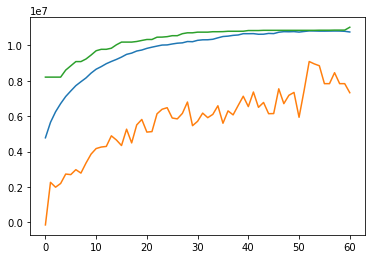

In [9]:
plt.plot(att.drop(["gen", "nevals", "std"], axis=1))

Exportando valores.

In [10]:
individual = hof.items[0]
caminhoes = pd.DataFrame([
    [0, individual[0], individual[1], individual[2], individual[3], individual[4], 0],
    [individual[5], individual[6], 0, individual[7], 0, individual[8], individual[9]],
    [0, individual[10], 0, 0, individual[11], 0, individual[12]],
    [individual[13], 0, individual[14], 0, individual[15], individual[16], 0],
    [0, individual[17], individual[18], 0, 0, 0, individual[19]],
    [0, 0, 0, individual[20], individual[21], individual[22], individual[23]],
    [individual[24], 0, 0, individual[25], individual[26], 0, 0]
  ])

In [11]:
caminhoes.to_csv("resposta.csv")
att.to_csv("estatisticas.csv")